In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

pd.set_option('display.max_columns', None)

In [2]:
bbb_df = pd.read_csv("data/bbb_reindexed.csv", index_col="ball_id")

In [3]:
bbb_df.columns

Index(['match_id', 'match_date', 'dl', 'gender', 'venue', 'innings',
       'bat_team', 'bowl_team', 'over', 'ball', 'batter', 'batter_name',
       'bowler', 'bowler_name', 'non_striker', 'runs_batter', 'runs_extras',
       'runs_total', 'wicket_type', 'player_out', 'bat_team_player_1',
       'bat_team_player_2', 'bat_team_player_3', 'bat_team_player_4',
       'bat_team_player_5', 'bat_team_player_6', 'bat_team_player_7',
       'bat_team_player_8', 'bat_team_player_9', 'bat_team_player_10',
       'bat_team_player_11', 'bowl_team_top_bowler_1',
       'bowl_team_top_bowler_2', 'bowl_team_top_bowler_3',
       'bowl_team_top_bowler_4', 'bowl_team_top_bowler_5', 'batter_total_runs',
       'batter_balls_faced', 'bowler_total_runs', 'bowler_balls_bowled',
       'team_total_runs', 'wickets_taken', 'rr', 'target', 'remaining_balls',
       'rrr'],
      dtype='object')

In [4]:
players_df = pd.read_csv("data/player_data.csv")
players_df.columns

Index(['player_id', 'player_name', 'cricinfo_id', 'bat_style', 'bowl_style',
       'bat_hand', 'bowl_hand', 'bowl_style_simple'],
      dtype='object')

In [5]:
grouped_venue =  bbb_df.groupby("venue")
grouped_venue.first()

,match_id,match_date,dl,gender,innings,bat_team,bowl_team,over,ball,batter,batter_name,bowler,bowler_name,non_striker,runs_batter,runs_extras,runs_total,wicket_type,player_out,bat_team_player_1,bat_team_player_2,bat_team_player_3,bat_team_player_4,bat_team_player_5,bat_team_player_6,bat_team_player_7,bat_team_player_8,bat_team_player_9,bat_team_player_10,bat_team_player_11,bowl_team_top_bowler_1,bowl_team_top_bowler_2,bowl_team_top_bowler_3,bowl_team_top_bowler_4,bowl_team_top_bowler_5,batter_total_runs,batter_balls_faced,bowler_total_runs,bowler_balls_bowled,team_total_runs,wickets_taken,rr,target,remaining_balls,rrr
venue,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AMI Stadium,300441,2008-02-23,True,male,1,England,New Zealand,0,1,f41598c1,AN Cook,7fb32e5b,KD Mills,1b6fef02,1,0,1,caught,1b6fef02,f41598c1,1b6fef02,33155d1b,39f01cdb,a386e91b,7bf96684,cca50cd6,3edb58fc,eba6a852,9dca07d7,d12143bf,7fb32e5b,d7c6af50,f5821615,57efa3be,3eac9d95,1,1,1,1,1,0,6.0,243.0,299,4.876254
Adelaide Oval,65638,2003-01-17,False,male,1,England,Sri Lanka,0,1,ea42ddb9,ME Trescothick,bcce309e,WPUJC Vaas,d2f3829d,0,0,0,bowled,ea42ddb9,ea42ddb9,d2f3829d,6e1b1ec0,f76ffa81,a8ce3491,818e8bf2,a386e91b,f011dfa3,25020f9d,d12143bf,c16d2e28,bcce309e,342d8ade,f233bbb4,9f62b897,34ff9e07,0,1,0,1,0,0,0.0,280.0,299,5.618729
Affies Park,1174844,2019-04-27,False,male,1,United States of America,Papua New Guinea,0,1,ffb504b1,XM Marshall,87a92b6b,N Pokana,25d7f1ac,4,0,4,caught,ffb504b1,ffb504b1,25d7f1ac,a9231c3f,17aa4f1d,9633359f,1ac2a995,95fcbfb7,a6bab2a9,5ec41cd7,c8a3f688,b0eaaac6,a36915ce,4d84ad05,87a92b6b,9920dd86,053f3ce3,4,1,4,1,4,0,24.0,165.0,299,3.311037
Al Amerat Cricket Ground Oman Cricket (Ministry Turf 1),1211169,2020-01-05,False,male,1,United Arab Emirates,Oman,0,1,6176f240,Chirag Suri,dcdb87f2,Bilal Khan,cddafe26,0,0,0,caught,cddafe26,6176f240,cddafe26,07b6f54c,adbf0400,45642393,d1988788,e5309baa,3df3f50b,d07dbc28,79b4839e,84dc72db,dcdb87f2,934b36a6,34464143,72253b87,2ef4f045,0,1,0,1,0,0,0.0,171.0,299,3.431438
Al Amerat Cricket Ground Oman Cricket (Ministry Turf 2),1276293,2021-09-06,False,male,1,Papua New Guinea,United States of America,0,1,a82eb3fb,TP Ura,c8a3f688,SN Netravalkar,6b4593ee,1,0,1,caught,6b4593ee,a82eb3fb,6b4593ee,72e60730,4d84ad05,9a95bebb,365229a8,c3564c2d,9dc3ea7e,d996ba33,053f3ce3,87a92b6b,c6e10e5c,c8a3f688,f7d267f7,e6ddab51,9633359f,1,1,1,1,1,0,6.0,159.0,299,3.190635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YMCA Cricket Club,644945,2013-07-19,False,female,1,Pakistan,Ireland,0,1,d921449d,Javeria Khan,77c88f05,LN McCarthy,a99085e6,1,0,1,caught,a99085e6,d921449d,a99085e6,5486d41f,3b770527,ed840f44,b287e7b1,98dfe425,2ea9b32c,bf8c8572,b1e5dade,3cfbddce,77c88f05,50ee0500,0b69a844,b4f73b44,e1556297,1,1,1,1,1,0,6.0,249.0,299,4.996656
Zahur Ahmed Chowdhury Stadium,486526,2010-12-12,False,male,1,Zimbabwe,Bangladesh,0,1,53597be1,BRM Taylor,e186f49c,Mashrafe Mortaza,31fbf891,0,1,1,run out,53597be1,53597be1,31fbf891,df08c69e,c96311d4,75de770f,d2babdd5,9de271ef,2f0d7e4a,9f0270e0,67af6f81,49691d7a,7dc35884,888e32bf,02e83ac5,e186f49c,8fb49ef8,0,0,1,0,1,0,6.0,189.0,299,3.792642
"Zahur Ahmed Chowdhury Stadium, Chattogram",1340847,2022-12-10,False,male,1,India,Bangladesh,0,1,0a476045,S Dhawan,0a8fce53,Mustafizur Rahman,752f7486,0,0,0,lbw,0a476045,0a476045,752f7486,ba607b88,85ec8e33,b17e2f24,f19ccfad,2e171977,1abb78f8,8d2c70ad,2f49c897,81c08fa3,0a8fce53,7dc35884,c58b0108,ef18b66e,cb5100f1,0,1,0,1,0,0,0.0,410.0,299,8.227425


In [6]:
# Merge bowler style and batter hand into ball-by-ball
bbb = bbb_df.merge(
    players_df[['player_id', 'bowl_style_simple']],
    left_on='bowler', right_on='player_id', how='left'
).rename(columns={'bowl_style_simple': 'bowler_style'})

bbb = bbb.merge(
    players_df[['player_id', 'bat_hand']],
    left_on='batter', right_on='player_id', how='left'
).rename(columns={'bat_hand': 'batter_hand'})

# Identify wickets
wickets = bbb[bbb['wicket_type'].notna()].copy()
wickets = wickets[wickets["wicket_type"] != "run out"]

# Aggregate wickets per match, style, venue
wkt_per_match = (
    wickets.groupby(['venue', 'match_id', 'bowler_style'])
    .size()
    .reset_index(name='wickets')
)

# Pivot to wide form
wkt_wide = wkt_per_match.pivot_table(
    index=['venue', 'match_id'],
    columns='bowler_style', values='wickets', fill_value=0
).add_suffix('_wickets').reset_index()

# Prepare batting runs per match, hand
runs_per_match = (
    bbb.groupby(['venue', 'match_id', 'batter_hand'])['runs_batter']
    .sum()
    .reset_index()
)

runs_wide = runs_per_match.pivot_table(
    index=['venue', 'match_id'],
    columns='batter_hand', values='runs_batter', fill_value=0
).add_prefix('runs_').add_suffix('_hand').reset_index()

# Combine match-level wicket and run stats
stats = pd.merge(wkt_wide, runs_wide, on=['venue', 'match_id'], how='outer').fillna(0)

# Sort by venue and match_date for rolling computations
# First get match_date
match_dates = bbb_df[['venue', 'match_id', 'match_date']].drop_duplicates()
match_dates['match_date'] = pd.to_datetime(match_dates['match_date'])
stats = stats.merge(match_dates, on=['venue', 'match_id'])
stats = stats.sort_values(['venue', 'match_date']).reset_index(drop=True)

# Compute cumulative and recent averages
grouped = stats.groupby('venue')

for col in stats.columns:
    if col.endswith('_wickets'):
        # cumulative sum
        stats[f'sum_{col}'] = grouped[col].cumsum()
        # recent 5-match average
        stats[f'recent_{col}'] = grouped[col].rolling(5, min_periods=1).mean().reset_index(level=0, drop=True)
    if col.startswith('runs_'):
        # cumulative sum of runs
        stats[f'sum_{col}'] = grouped[col].cumsum()
        # recent 5-match average of runs
        stats[f'recent_{col}'] = grouped[col].rolling(5, min_periods=1).mean().reset_index(level=0, drop=True)

# Reorder columns
cols = ['venue', 'match_id'] + \
       [c for c in stats.columns if c not in ['venue','match_id','match_date']]
stats_final = stats[cols]

# Save to CSV
stats_final.to_csv("data/venue_match_stats.csv", index=False)

In [7]:
bbb_df[
    (bbb_df["match_id"] == 300441) &
    (bbb_df["wicket_type"].notna())
]

,match_id,match_date,dl,gender,venue,innings,bat_team,bowl_team,over,ball,batter,batter_name,bowler,bowler_name,non_striker,runs_batter,runs_extras,runs_total,wicket_type,player_out,bat_team_player_1,bat_team_player_2,bat_team_player_3,bat_team_player_4,bat_team_player_5,bat_team_player_6,bat_team_player_7,bat_team_player_8,bat_team_player_9,bat_team_player_10,bat_team_player_11,bowl_team_top_bowler_1,bowl_team_top_bowler_2,bowl_team_top_bowler_3,bowl_team_top_bowler_4,bowl_team_top_bowler_5,batter_total_runs,batter_balls_faced,bowler_total_runs,bowler_balls_bowled,team_total_runs,wickets_taken,rr,target,remaining_balls,rrr
ball_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
300156,300441,2008-02-23,True,male,AMI Stadium,1,England,New Zealand,2,2,1b6fef02,P Mustard,7fb32e5b,KD Mills,f41598c1,0,0,0,caught,1b6fef02,f41598c1,1b6fef02,33155d1b,39f01cdb,a386e91b,7bf96684,cca50cd6,3edb58fc,eba6a852,9dca07d7,d12143bf,7fb32e5b,d7c6af50,f5821615,57efa3be,3eac9d95,2,8,2,8,5,1,2.142857,NaN,286,NaN
300228,300441,2008-02-23,True,male,AMI Stadium,1,England,New Zealand,14,1,33155d1b,IR Bell,7fb32e5b,KD Mills,f41598c1,0,0,0,caught,33155d1b,f41598c1,1b6fef02,33155d1b,39f01cdb,a386e91b,7bf96684,cca50cd6,3edb58fc,eba6a852,9dca07d7,d12143bf,7fb32e5b,d7c6af50,f5821615,57efa3be,3eac9d95,24,33,16,41,57,2,4.023529,NaN,215,NaN
300294,300441,2008-02-23,True,male,AMI Stadium,1,England,New Zealand,25,1,f41598c1,AN Cook,d7c6af50,DL Vettori,39f01cdb,0,0,0,lbw,f41598c1,f41598c1,1b6fef02,33155d1b,39f01cdb,a386e91b,7bf96684,cca50cd6,3edb58fc,eba6a852,9dca07d7,d12143bf,7fb32e5b,d7c6af50,f5821615,57efa3be,3eac9d95,42,69,13,25,105,3,4.172185,NaN,149,NaN
300325,300441,2008-02-23,True,male,AMI Stadium,1,England,New Zealand,30,2,39f01cdb,KP Pietersen,f5821615,JS Patel,a386e91b,0,0,0,caught,39f01cdb,f41598c1,1b6fef02,33155d1b,39f01cdb,a386e91b,7bf96684,cca50cd6,3edb58fc,eba6a852,9dca07d7,d12143bf,7fb32e5b,d7c6af50,f5821615,57efa3be,3eac9d95,39,55,1,2,119,4,3.923077,NaN,118,NaN
300347,300441,2008-02-23,True,male,AMI Stadium,1,England,New Zealand,33,6,a386e91b,PD Collingwood,d7c6af50,DL Vettori,7bf96684,0,0,0,stumped,a386e91b,f41598c1,1b6fef02,33155d1b,39f01cdb,a386e91b,7bf96684,cca50cd6,3edb58fc,eba6a852,9dca07d7,d12143bf,7fb32e5b,d7c6af50,f5821615,57efa3be,3eac9d95,14,27,28,54,128,5,3.764706,NaN,96,NaN
300421,300441,2008-02-23,True,male,AMI Stadium,1,England,New Zealand,46,2,cca50cd6,LJ Wright,7fb32e5b,KD Mills,7bf96684,0,0,0,caught,cca50cd6,f41598c1,1b6fef02,33155d1b,39f01cdb,a386e91b,7bf96684,cca50cd6,3edb58fc,eba6a852,9dca07d7,d12143bf,7fb32e5b,d7c6af50,f5821615,57efa3be,3eac9d95,47,39,24,48,197,6,4.251799,NaN,22,NaN
300424,300441,2008-02-23,True,male,AMI Stadium,1,England,New Zealand,46,5,7bf96684,OA Shah,7fb32e5b,KD Mills,3edb58fc,0,0,0,caught,7bf96684,f41598c1,1b6fef02,33155d1b,39f01cdb,a386e91b,7bf96684,cca50cd6,3edb58fc,eba6a852,9dca07d7,d12143bf,7fb32e5b,d7c6af50,f5821615,57efa3be,3eac9d95,29,48,28,51,201,7,4.291815,NaN,19,NaN
300515,300441,2008-02-23,True,male,AMI Stadium,2,New Zealand,England,11,2,b8a55852,BB McCullum,a386e91b,PD Collingwood,91ffa6c6,0,0,0,run out,91ffa6c6,91ffa6c6,b8a55852,fd8f11e9,b61a3e1a,57efa3be,9d710afe,3eac9d95,d7c6af50,7fb32e5b,f5821615,05e0fab5,9dca07d7,d12143bf,a386e91b,eba6a852,3edb58fc,72,36,0,2,103,1,9.088235,243.0,232,6.284483
300543,300441,2008-02-23,True,male,AMI Stadium,2,New Zealand,England,15,6,b8a55852,BB McCullum,a386e91b,PD Collingwood,fd8f11e9,0,0,0,bowled,b8a55852,91ffa6c6,b8a55852,fd8f11e9,b61a3e1a,57efa3be,9d710afe,3eac9d95,d7c6af50,7fb32e5b,f5821615,05e0fab5,9dca07d7,d12143bf,a386e91b,eba6a852,3edb58fc,77,43,4,18,118,2,7.375000,243.0,204,7.147059


In [9]:
bbb_df['venue'].unique()

array(['McLean Park, Napier', 'Jade Stadium, Christchurch',
       'Davies Park, Queenstown', 'Westpac Stadium, Wellington',
       'Sydney Cricket Ground', 'Bellerive Oval, Hobart',
       'Westpac Park, Hamilton',
       'Brisbane Cricket Ground, Woolloongabba, Brisbane',
       'Adelaide Oval', 'Melbourne Cricket Ground', 'Newlands, Cape Town',
       'Harare Sports Club', 'Goodyear Park, Bloemfontein',
       'New Wanderers Stadium, Johannesburg', 'Kingsmead, Durban',
       'North West Cricket Stadium, Potchefstroom',
       'Boland Bank Park, Paarl', "St George's Park, Port Elizabeth",
       'SuperSport Park, Centurion', 'Buffalo Park, East London',
       'De Beers Diamond Oval, Kimberley', 'Willowmoore Park, Benoni',
       'City Oval, Pietermaritzburg', 'Gymkhana Club Ground, Nairobi',
       'Queens Sports Club, Bulawayo',
       'Sharjah Cricket Association Stadium',
       'Bangabandhu National Stadium, Dhaka',
       'Rangiri Dambulla International Stadium',
       'Sabin

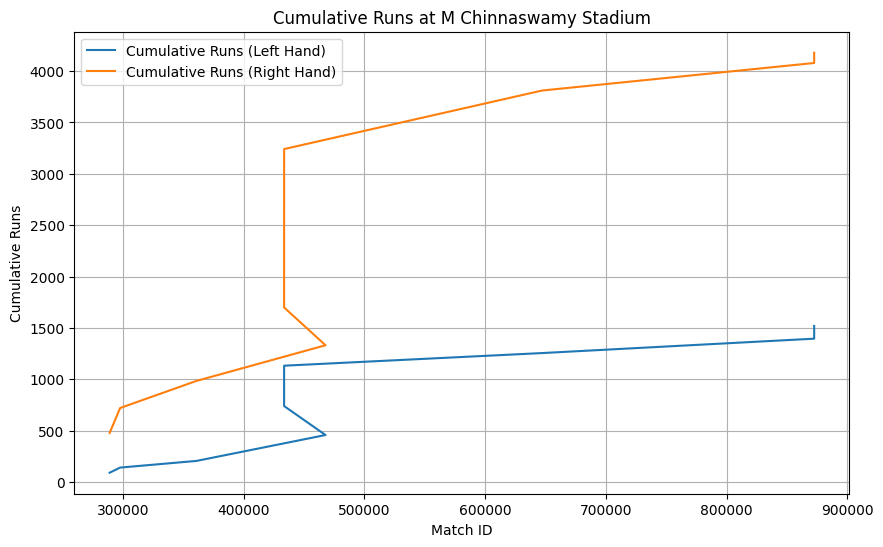

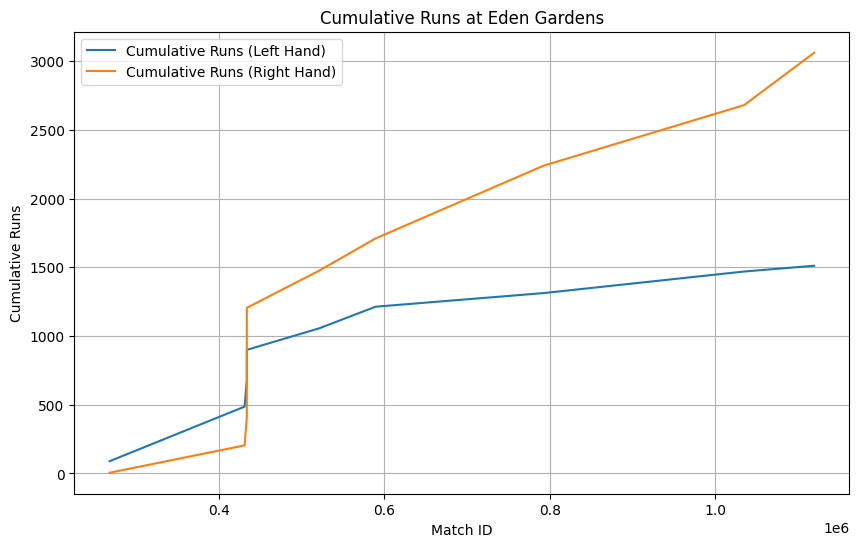

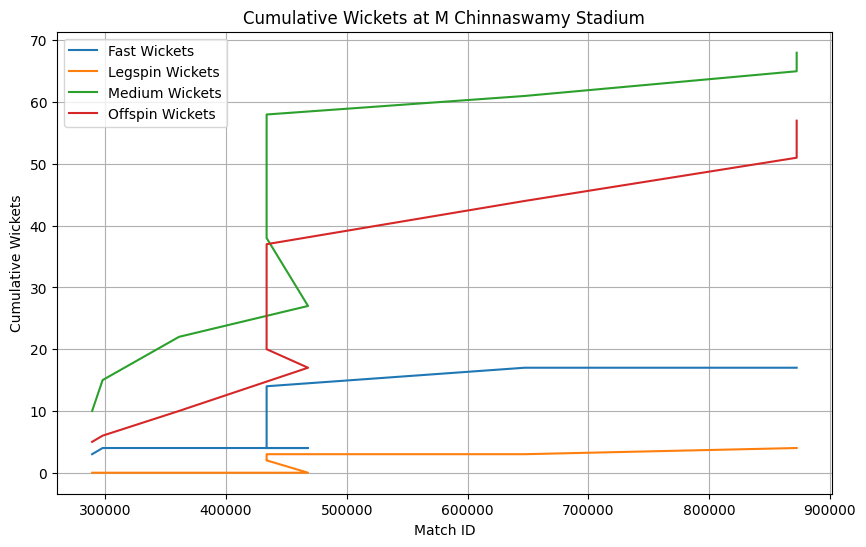

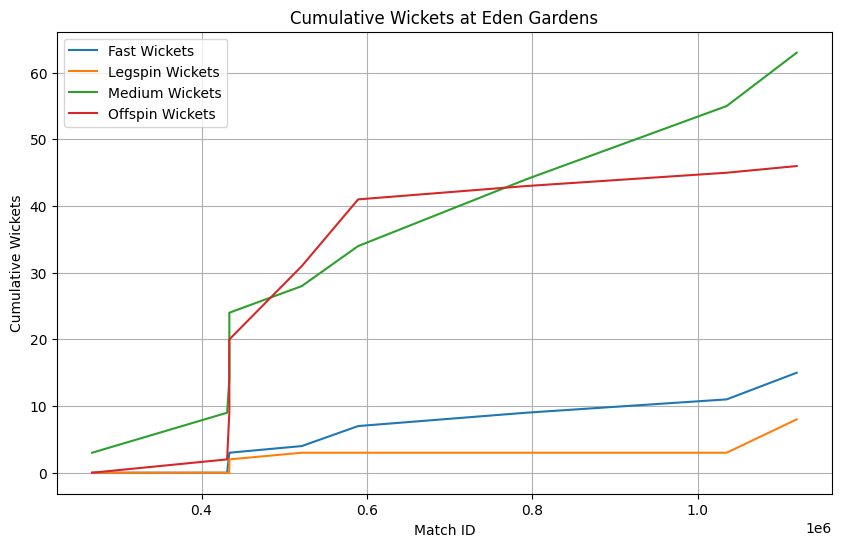

In [11]:
# Filter stats_final for the two venues
venues_to_plot = ['M Chinnaswamy Stadium', 'Eden Gardens']
filtered_stats = stats_final[stats_final['venue'].isin(venues_to_plot)]

# Plot the stats
import matplotlib.pyplot as plt

# Plot cumulative runs for left and right-hand batters
for venue in venues_to_plot:
    venue_data = filtered_stats[filtered_stats['venue'] == venue]
    plt.figure(figsize=(10, 6))
    plt.plot(venue_data['match_id'], venue_data['sum_runs_left_hand'], label='Cumulative Runs (Left Hand)')
    plt.plot(venue_data['match_id'], venue_data['sum_runs_right_hand'], label='Cumulative Runs (Right Hand)')
    plt.title(f'Cumulative Runs at {venue}')
    plt.xlabel('Match ID')
    plt.ylabel('Cumulative Runs')
    plt.legend()
    plt.grid()
    plt.show()

# Plot cumulative wickets for different bowler styles
for venue in venues_to_plot:
    venue_data = filtered_stats[filtered_stats['venue'] == venue]
    plt.figure(figsize=(10, 6))
    plt.plot(venue_data['match_id'], venue_data['sum_fast_wickets'], label='Fast Wickets')
    plt.plot(venue_data['match_id'], venue_data['sum_legspin_wickets'], label='Legspin Wickets')
    plt.plot(venue_data['match_id'], venue_data['sum_medium_wickets'], label='Medium Wickets')
    plt.plot(venue_data['match_id'], venue_data['sum_offspin_wickets'], label='Offspin Wickets')
    plt.title(f'Cumulative Wickets at {venue}')
    plt.xlabel('Match ID')
    plt.ylabel('Cumulative Wickets')
    plt.legend()
    plt.grid()
    plt.show()